In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import math
import numpy as np

In [58]:
df = pd.read_csv('BMED_DATA_AG.csv')
#df = df[df['exp'].isin([0, 1])]
df

,exp,V,E,t,VF,VA,VB,CFLA,CALA,CFK,CBK,I
0,0,20,0.25,0.00,1.000000,1.000000,1.000000,0.495147,0.000518,1.083763,0.011514,0.000000
1,0,20,0.25,0.25,1.008596,0.997544,0.993860,0.490314,0.001626,0.954817,0.136444,0.120313
2,0,20,0.25,0.50,1.016095,0.995401,0.988503,0.485344,0.003696,0.841070,0.246838,0.229167
3,0,20,0.25,0.75,1.021399,0.993886,0.984715,0.480242,0.006447,0.749887,0.335982,0.323438
4,0,20,0.25,1.00,1.023411,0.993311,0.983278,0.475013,0.009596,0.688634,0.397163,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...
587,23,35,0.50,6.00,0.282901,1.443299,2.273113,0.253424,2.204487,0.041429,1.184012,3.404974
588,23,35,0.50,6.25,0.263436,1.443299,2.291290,0.168860,2.222514,0.025455,1.181657,2.937112
589,23,35,0.50,6.50,0.248414,1.443299,2.306515,0.104276,2.235851,0.013400,1.176642,2.319837
590,23,35,0.50,6.75,0.239264,1.443299,2.316642,0.065264,2.243695,0.006190,1.169461,1.588445


In [59]:
def set_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        print(f'Using device: {device}')
        print(f'GPU: {torch.cuda.get_device_name(0)}')
    else:
        print(f'Using device: {device}')

    return device

In [60]:
def norm_data(df):
    df = df
    ndf = pd.DataFrame()
    range_mm={
        'V': {'min':df['V'].min()*0.8, 'max': df['V'].max()*1.2},
        'E': {'min':df['E'].min()*0.8, 'max': df['E'].max()*1.2},
        'VF': {'min':df['VF'].min()*0.8, 'max': df['VF'].max()*1.2},
        'VA': {'min':df['VA'].min()*0.8, 'max': df['VA'].max()*1.2},
        'VB': {'min':df['VB'].min()*0.8, 'max': df['VB'].max()*1.2},
        'CFLA': {'min':0, 'max': df['CFLA'].max()*1.2},
        'CALA': {'min':0, 'max': df['CALA'].max()*1.2},
        'CFK': {'min':0, 'max': df['CFK'].max()*1.2},
        'CBK': {'min':0, 'max': df['CBK'].max()*1.2},
        'I': {'min':0, 'max': df['I'].max()*1.2},
    }

    ndf['exp'] = df['exp']; ndf['t'] = df['t']

    for col in ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']:
        if col in range_mm:
            ndf[col] = (df[col] - range_mm[col]['min'])/(range_mm[col]['max'] - range_mm[col]['min'])
        else:
            ndf[col] = df[col]

    # Get the unique experiment numbers in order
    exp_num_list = sorted(ndf['exp'].unique())
    return ndf, exp_num_list

In [61]:
ndf, exp_num_list = norm_data(df)
ndf

,exp,t,V,E,VF,VA,VB,CFLA,CALA,CFK,CBK,I
0,0,0.00,0.352941,0.05,0.488273,0.345478,0.037749,0.122495,0.000192,0.163946,0.003634,0.000000
1,0,0.25,0.352941,0.05,0.493454,0.343535,0.036812,0.121299,0.000603,0.144439,0.043062,0.022786
2,0,0.50,0.352941,0.05,0.497975,0.341840,0.035995,0.120069,0.001372,0.127232,0.077902,0.043403
3,0,0.75,0.352941,0.05,0.501172,0.340642,0.035418,0.118807,0.002393,0.113439,0.106035,0.061257
4,0,1.00,0.352941,0.05,0.502384,0.340187,0.035198,0.117514,0.003562,0.104173,0.125344,0.075758
...,...,...,...,...,...,...,...,...,...,...,...,...
587,23,6.00,0.794118,0.30,0.056038,0.696149,0.231905,0.062695,0.818206,0.006267,0.373672,0.644881
588,23,6.25,0.794118,0.30,0.044305,0.696149,0.234677,0.041774,0.824896,0.003851,0.372929,0.556271
589,23,6.50,0.794118,0.30,0.035251,0.696149,0.236998,0.025797,0.829846,0.002027,0.371346,0.439363
590,23,6.75,0.794118,0.30,0.029735,0.696149,0.238543,0.016146,0.832758,0.000936,0.369080,0.300842


In [62]:
def seq_data(ndf):
    seq = []
    # CBLA, CAK만 제거: 학습 불안정성 때문에
    # 전류(I)는 포함: ground truth로 사용하여 예측 성능 비교
    feature_cols = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    
    for exp in ndf['exp'].unique():
        exp_data = ndf[ndf['exp'] == exp].sort_values(by='t')
        seq.append(exp_data[feature_cols].values)
    
    return seq
seq = seq_data(ndf)
seq

[array([[3.52941176e-01, 5.00000000e-02, 4.88272978e-01, 3.45478087e-01,
         3.77487200e-02, 1.22494711e-01, 1.92310066e-04, 1.63945555e-01,
         3.63387447e-03, 0.00000000e+00],
        [3.52941176e-01, 5.00000000e-02, 4.93454482e-01, 3.43535191e-01,
         3.68123008e-02, 1.21299066e-01, 6.03421788e-04, 1.44439367e-01,
         4.30615689e-02, 2.27864583e-02],
        [3.52941176e-01, 5.00000000e-02, 4.97974518e-01, 3.41840325e-01,
         3.59954245e-02, 1.20069486e-01, 1.37191324e-03, 1.27232390e-01,
         7.79016856e-02, 4.34027778e-02],
        [3.52941176e-01, 5.00000000e-02, 5.01171616e-01, 3.40641517e-01,
         3.54176340e-02, 1.18807253e-01, 2.39292864e-03, 1.13438779e-01,
         1.06035376e-01, 6.12571023e-02],
        [3.52941176e-01, 5.00000000e-02, 5.02384308e-01, 3.40186796e-01,
         3.51984720e-02, 1.17513651e-01, 3.56161221e-03, 1.04172687e-01,
         1.25343793e-01, 7.57575758e-02],
        [3.52941176e-01, 5.00000000e-02, 5.02384308e-01, 3.4

In [63]:
def pad_seq(seq):
    max_len = max([len(seq) for seq in seq])
    seq_len = [len(seq) for seq in seq]
    pad_seq = pad_sequence([torch.tensor(seq) for seq in seq], batch_first=True, padding_value=-1)

    return pad_seq, seq_len, max_len
pad_seq, seq_len, max_len = pad_seq(seq)

In [64]:
def gen_dataset(pad_seq, seq_len):
    input_tensor = pad_seq.float()
    seq_len_tensor = torch.tensor(seq_len)
    dataset = TensorDataset(input_tensor, seq_len_tensor)
    return dataset
dataset = gen_dataset(pad_seq, seq_len)
dataset[0]

(tensor([[ 3.5294e-01,  5.0000e-02,  4.8827e-01,  3.4548e-01,  3.7749e-02,
           1.2249e-01,  1.9231e-04,  1.6395e-01,  3.6339e-03,  0.0000e+00],
         [ 3.5294e-01,  5.0000e-02,  4.9345e-01,  3.4354e-01,  3.6812e-02,
           1.2130e-01,  6.0342e-04,  1.4444e-01,  4.3062e-02,  2.2786e-02],
         [ 3.5294e-01,  5.0000e-02,  4.9797e-01,  3.4184e-01,  3.5995e-02,
           1.2007e-01,  1.3719e-03,  1.2723e-01,  7.7902e-02,  4.3403e-02],
         [ 3.5294e-01,  5.0000e-02,  5.0117e-01,  3.4064e-01,  3.5418e-02,
           1.1881e-01,  2.3929e-03,  1.1344e-01,  1.0604e-01,  6.1257e-02],
         [ 3.5294e-01,  5.0000e-02,  5.0238e-01,  3.4019e-01,  3.5198e-02,
           1.1751e-01,  3.5616e-03,  1.0417e-01,  1.2534e-01,  7.5758e-02],
         [ 3.5294e-01,  5.0000e-02,  5.0238e-01,  3.4019e-01,  3.5198e-02,
           1.1626e-01,  4.9916e-03,  9.8660e-02,  1.3721e-01,  8.7003e-02],
         [ 3.5294e-01,  5.0000e-02,  5.0238e-01,  3.4019e-01,  3.5198e-02,
           1.1502e-

In [65]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [66]:
class LayerNormLSTMCell(nn.Module):
    """LSTM Cell with Layer Normalization applied to gates"""
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node
        
        # Input-to-hidden and hidden-to-hidden transformations
        self.weight_ih = nn.Linear(input_node, 4 * hidden_node, bias=False)
        self.weight_hh = nn.Linear(hidden_node, 4 * hidden_node, bias=False)
        
        # Layer normalization for each gate
        self.ln_i = nn.LayerNorm(hidden_node)  # Input gate
        self.ln_f = nn.LayerNorm(hidden_node)  # Forget gate  
        self.ln_g = nn.LayerNorm(hidden_node)  # Cell gate
        self.ln_o = nn.LayerNorm(hidden_node)  # Output gate
        
        # Cell state layer norm
        self.ln_c = nn.LayerNorm(hidden_node)
        
    def forward(self, input, hidden):
        h_prev, c_prev = hidden
        
        # Input-to-hidden and hidden-to-hidden transformations
        gi = self.weight_ih(input)    # [batch, 4*hidden_size] - 입력에 대한 4개 게이트 계산
        gh = self.weight_hh(h_prev)   # [batch, 4*hidden_size] - 이전 히든 상태에 대한 4개 게이트 계산
        i_i, i_f, i_g, i_o = gi.chunk(4, 1)
        h_i, h_f, h_g, h_o = gh.chunk(4, 1)
        
        # Apply layer normalization to each gate
        i_gate = torch.sigmoid(self.ln_i(i_i + h_i))
        f_gate = torch.sigmoid(self.ln_f(i_f + h_f))  
        g_gate = torch.tanh(self.ln_g(i_g + h_g))
        o_gate = torch.sigmoid(self.ln_o(i_o + h_o))
        
        # Update cell state with layer norm
        c_new = f_gate * c_prev + i_gate * g_gate
        c_new = self.ln_c(c_new)
        
        # Update hidden state
        h_new = o_gate * torch.tanh(c_new)
        
        return h_new, c_new

class StateExtr(nn.Module):
    def __init__(self, input_node, hidden_node, nlayer, dropout=0.2):
        super().__init__()
        self.hidden_node = hidden_node
        self.nlayer = nlayer
        self.input_size = input_node
        
        # Create LayerNorm LSTM layers
        self.lstm_cells = nn.ModuleList()
        
        # First layer: input_size -> hidden_size
        self.lstm_cells.append(LayerNormLSTMCell(input_node, hidden_node))
        
        # Additional layers: hidden_size -> hidden_size
        for _ in range(nlayer - 1):
            self.lstm_cells.append(LayerNormLSTMCell(hidden_node, hidden_node))
        
        # Dropout between layers (only applied if nlayer > 1)
        self.dropout = nn.Dropout(dropout) if nlayer > 1 else nn.Identity()
        
        # Final layer norm and dropout
        self.final_layer_norm = nn.LayerNorm(hidden_node)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        """
        시계열 상태 시퀀스를 처리하여 각 시점의 hidden state 추출
        
        Args:
            x: [batch_size, seq_len, input_size] - BMED 시스템 상태 시퀀스
            seq_len: [batch_size] - 각 시퀀스의 실제 길이
            
        Returns:
            hidden_states: [batch_size, seq_len, hidden_size] - 각 시점의 누적된 hidden state
        """
        
        # 입력 검증
        if x.size(0) != seq_len.size(0):
            raise ValueError(f"Batch size mismatch: input {x.size(0)} vs seq_len {seq_len.size(0)}")
        
        batch_size, max_len, input_node = x.size()
        device = x.device
        
        # 초기 hidden/cell states 초기화
        h_states = []
        c_states = []
        for _ in range(self.nlayer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
        
        # 각 시점별 출력 저장
        outputs = []
        
        # 시점별로 순차 처리
        for t in range(max_len):
            x_t = x[:, t, :]  # [batch_size, input_node]
            
            # 각 LSTM layer 순차 처리
            layer_input = x_t
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))
                
                # 상태 업데이트
                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new
                
                # 다음 레이어 입력 준비 (dropout 적용)
                if layer_idx < len(self.lstm_cells) - 1:  # 마지막 레이어가 아닌 경우
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new
            
            outputs.append(layer_input)
        
        # [batch_size, seq_len, hidden_size] 형태로 변환
        output_tensor = torch.stack(outputs, dim=1)
        
        # 시퀀스 길이에 따른 마스킹 (패딩 부분 0으로 설정)
        seq_len_cpu = seq_len.detach().cpu().long()
        
        # 시퀀스 길이 유효성 검사
        if (seq_len_cpu <= 0).any():
            invalid_lengths = seq_len_cpu[seq_len_cpu <= 0]
            raise ValueError(f"Invalid sequence lengths detected: {invalid_lengths.tolist()}. All sequence lengths must be positive.")
        
        # 마스크 생성 및 적용
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)  # [batch, seq_len, 1]
        
        # 마스킹 적용
        masked_output = output_tensor * mask
        
        # Final normalization and dropout
        normalized = self.final_layer_norm(masked_output)
        return self.final_dropout(normalized)

In [67]:
class PhysicalChangeDecoder(nn.Module):
    """
    Hidden state로부터 BMED 시스템의 물리적 변화량과 새로운 전류값을 디코딩하는 MLP
    출력: [dVA, dVB, dNALA, dNBK, nI] - 5개 물리적 변화량 (CBLA, CAK 제거로 dNBLA, dNAK 불필요)
    """
    def __init__(self, hidden_size, output_size, num_layers=2, num_nodes=None, dropout=0.3):
        super().__init__()

        if num_nodes is None:
            num_nodes = hidden_size
        
        self.layers = nn.ModuleList()

        # 첫 번째 레이어: hidden_size → num_nodes
        self.layers.append(nn.Linear(hidden_size, num_nodes))
        self.layers.append(nn.LayerNorm(num_nodes))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        # 중간 은닉층들: num_nodes → num_nodes
        for i in range(num_layers - 1):
            self.layers.append(nn.Linear(num_nodes, num_nodes))
            self.layers.append(nn.LayerNorm(num_nodes))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        # 마지막 출력층: num_nodes → output_size (5개 물리적 변화량)
        self.layers.append(nn.Linear(num_nodes, output_size))

    def forward(self, hidden_states):
        """
        Hidden state를 물리적 변화량으로 디코딩
        
        Args:
            hidden_states: [batch_size, seq_len, hidden_size] - 시점별 hidden state
            
        Returns:
            physical_changes: [batch_size, seq_len, 5] - 물리적 변화량
                [dVA, dVB, dNALA, dNBK, nI]
        """
        x = hidden_states
        for layer in self.layers:
            x = layer(x)
        return x

In [68]:
class PhysicsConstraintLayer(nn.Module):
    """
    물리적 변화량을 실제 시스템 상태로 변환하면서 물리적 제약 조건을 적용
    Bipolar membrane electrodialysis 시스템의 물리 법칙 기반 상태 업데이트
    CBLA, CAK는 완전히 제거되어 더 이상 존재하지 않음
    전류는 dependent variable이므로 input에 포함하지 않고 output으로만 예측
    """
    def __init__(self, eps=1e-1):
        super().__init__()
        self.eps = eps  # division by zero 방지
        
    def forward(self, physical_changes, current_state):
        """
        물리적 변화량을 현재 상태에 적용하여 다음 상태 계산
        
        Args:
            physical_changes: [batch, seq, 5] - [dVA, dVB, dNALA, dNBK, nI]
            current_state: [batch, seq, 9] - 현재 BMED 시스템 상태 (전류 제외)
                V, E, VF, VA, VB, CFLA, CALA, CFK, CBK
                
        Returns:
            next_state: [batch, seq, 10] - 물리 제약이 적용된 다음 상태
                V, E, VF, VA, VB, CFLA, CALA, CFK, CBK, I
        """
        # 입력 차원 검증
        if physical_changes.dim() != current_state.dim():
            raise ValueError(f"Dimension mismatch: physical_changes {physical_changes.shape} vs current_state {current_state.shape}")
        
        if current_state.size(-1) != 9:
            raise ValueError(f"Expected 9 state features, got {current_state.size(-1)}")
            
        if physical_changes.size(-1) != 5:
            raise ValueError(f"Expected 5 physical changes, got {physical_changes.size(-1)}")
        
        # 현재 상태 변수 추출 (9개)
        V = current_state[..., 0:1]     # 전압 (고정값)
        E = current_state[..., 1:2]     # 외부 전해질 농도 (고정값)
        VF = current_state[..., 2:3]    # Feed 부피
        VA = current_state[..., 3:4]    # Acid 부피
        VB = current_state[..., 4:5]    # Base 부피
        CFLA = current_state[..., 5:6]  # Feed LA 농도
        CALA = current_state[..., 6:7]  # Acid LA 농도
        CFK = current_state[..., 7:8]   # Feed K 농도
        CBK = current_state[..., 8:9]   # Base K 농도

        # 물질량 계산 (농도 × 부피) - CBLA, CAK 관련은 완전 제거
        NFLA = CFLA * VF
        NALA = CALA * VA  
        NFK = CFK * VF
        NBK = CBK * VB

        # 물리적 변화량 추출 (5개)
        dVA = physical_changes[..., 0:1]    # Acid 부피 변화량
        dVB = physical_changes[..., 1:2]    # Base 부피 변화량
        dNALA = physical_changes[..., 2:3]  # Acid LA 물질량 변화량 (F→A)
        dNBK = physical_changes[..., 3:4]   # Base K 물질량 변화량 (F→B)
        nI = physical_changes[..., 4:5]     # 새로운 전류값 (모델이 예측)

        # 새로운 부피 계산
        nVF = VF - dVA - dVB
        nVA = VA + dVA        
        nVB = VB + dVB        
        
        # 물질 이동량을 일방향으로 제한
        dNALA_clipped = torch.clamp(dNALA, min=0)  # F→A 이동만
        dNBK_clipped = torch.clamp(dNBK, min=0)    # F→B 이동만
        
        # 새로운 물질량 계산 (CBLA, CAK 관련 제거)
        nNFLA = NFLA - dNALA_clipped  # Feed에서 LA 유출
        nNALA = NALA + dNALA_clipped  # Acid로 LA 유입
        nNFK = NFK - dNBK_clipped     # Feed에서 K 유출  
        nNBK = NBK + dNBK_clipped     # Base로 K 유입
        
        # 물리적 제약 조건 적용 (양수 유지)
        nVF = torch.clamp(nVF, min=self.eps)
        nVA = torch.clamp(nVA, min=self.eps)
        nVB = torch.clamp(nVB, min=self.eps)
        
        # 물질량 음수 방지
        nNFLA = torch.clamp(nNFLA, min=0)
        nNALA = torch.clamp(nNALA, min=0)
        nNFK = torch.clamp(nNFK, min=0)
        nNBK = torch.clamp(nNBK, min=0)
        
        # 새로운 농도 계산
        nCFLA = nNFLA / nVF
        nCALA = nNALA / nVA
        nCFK = nNFK / nVF
        nCBK = nNBK / nVB
        
        # 전류는 양수 제약
        nI = torch.clamp(nI, min=0)

        # 새로운 상태 조립 (10개 변수, CBLA, CAK 완전 제거, 전류는 예측 결과로 추가)
        next_state = torch.cat([
            V, E,  # 고정값: 전압, 외부 전해질 농도
            nVF, nVA, nVB,  # 새로운 부피
            nCFLA, nCALA,   # 새로운 LA 농도 (CBLA 제거)
            nCFK, nCBK,     # 새로운 K 농도 (CAK 제거)
            nI  # 새로운 전류 (모델이 예측한 dependent variable)
        ], dim=-1)
        
        return next_state

In [69]:
class BMEDAutoregressiveModel(nn.Module):
    """
    BMED 시스템의 시계열 상태 예측을 위한 자기회귀 모델
    
    구조:
    1. StateExtr: LSTM으로 시계열 패턴의 hidden state 추출
    2. PhysicalChangeDecoder: Hidden state를 물리적 변화량으로 디코딩  
    3. PhysicsConstraintLayer: 물리 법칙 적용하여 다음 상태 계산
    """
    def __init__(self, state_extractor_params, decoder_params):
        super().__init__()
        self.state_extractor = StateExtr(**state_extractor_params)
        self.physical_decoder = PhysicalChangeDecoder(**decoder_params)
        self.physics_constraint = PhysicsConstraintLayer()

    def forward(self, current_states, seq_lengths):
        """
        현재 시점까지의 상태들로부터 다음 상태들 예측
        
        Args:
            current_states: [batch, seq_len, 9] - 현재까지의 전류를 제외한한 BMED 시스템 상태들
            seq_lengths: [batch] - 각 시퀀스의 실제 길이
            
        Returns:
            next_states: [batch, seq_len, 10] - 예측된 다음 시점 상태들 (전류 포함)
        """
        # 1. LSTM으로 각 시점의 hidden state 추출 (과거 정보 누적)
        hidden_states = self.state_extractor(current_states, seq_lengths)
        
        # 2. Hidden state를 물리적 변화량으로 디코딩
        physical_changes = self.physical_decoder(hidden_states)
        
        # 3. 물리적 제약 조건을 적용하여 다음 상태 계산
        next_states = self.physics_constraint(physical_changes, current_states)
        
        return next_states

In [70]:
def masked_mse_loss(predictions, targets, seq_lengths):
    """
    개선된 마스킹된 MSE 손실 함수 - device 호환성, 안정성 강화, feature별 가중치 적용
    
    Args:
        predictions: 모델 예측값 [batch_size, seq_len, features]
        targets: 실제 타겟값 [batch_size, seq_len, features]  
        seq_lengths: 각 시퀀스의 실제 길이 [batch_size]
    
    Returns:
        masked_loss: 패딩 부분을 제외한 가중 평균 MSE 손실
    """
    # 입력 검증
    if predictions.shape != targets.shape:
        raise ValueError(f"Shape mismatch: predictions {predictions.shape} vs targets {targets.shape}")
    
    if predictions.size(0) != seq_lengths.size(0):
        raise ValueError(f"Batch size mismatch: predictions {predictions.size(0)} vs seq_lengths {seq_lengths.size(0)}")
    
    batch_size, max_len, features = predictions.shape
    
    # seq_lengths를 CPU로 이동하여 arange와 호환되도록 처리
    seq_lengths_cpu = seq_lengths.detach().cpu().long()
    
    # 시퀀스 길이 유효성 검사
    if (seq_lengths_cpu <= 0).any():
        invalid_lengths = seq_lengths_cpu[seq_lengths_cpu <= 0]
        raise ValueError(f"Invalid sequence lengths detected: {invalid_lengths.tolist()}. All sequence lengths must be positive.")
    
    # 최대 길이 초과 검사
    if (seq_lengths_cpu > max_len).any():
        invalid_lengths = seq_lengths_cpu[seq_lengths_cpu > max_len]
        raise ValueError(f"Sequence lengths exceed max_len: {invalid_lengths.tolist()} > {max_len}")
    
    # 마스크 생성: 실제 시퀀스 길이만큼만 True
    mask = torch.arange(max_len, device='cpu')[None, :] < seq_lengths_cpu[:, None]
    mask = mask.float().to(predictions.device)
    
    # Feature별 가중치 정의 (10개 features: V, E, VF, VA, VB, CFLA, CALA, CFK, CBK, I)
    # VF(2), VA(3), CFLA(5), CALA(6), I(9)에 10배 가중치 적용
    feature_weights = torch.ones(features, device=predictions.device)
    high_weight_indices = [2, 3, 5, 6, 9]  # VF, VA, CFLA, CALA, I
    feature_weights[high_weight_indices] = 10.0
    
    # print(f"Feature weights applied: {feature_weights.cpu().numpy()}")
    # print(f"High weight features (x10): VF, VA, CFLA, CALA, I")
    
    # 각 요소별 MSE 계산 (reduction='none')
    loss = F.mse_loss(predictions, targets, reduction='none')  # [batch, seq_len, features]
    
    # Feature별 가중치 적용
    weighted_loss = loss * feature_weights.unsqueeze(0).unsqueeze(0)  # [batch, seq_len, features]
    
    # 마스크 적용하여 패딩 부분 제거
    masked_loss = weighted_loss * mask.unsqueeze(-1)  # [batch, seq_len, features]
    
    # 전체 손실 합계와 전체 valid elements 계산 (가중치 고려)
    total_loss = masked_loss.sum()
    total_elements = mask.sum() * feature_weights.sum()  # 가중치 합 고려
    
    # 0으로 나누기 방지
    if total_elements == 0:
        raise ValueError("No valid elements found after masking. Check sequence lengths and data.")
    
    masked_loss = total_loss / total_elements
    
    return masked_loss

In [71]:
def prepare_teacher_forcing_data(input_sequences, seq_lengths):
    """
    Teacher Forcing을 위한 입력-타겟 데이터 준비
    전류는 dependent variable이므로 input에서 제외하고 output에만 포함
    
    Args:
        input_sequences: 전체 시퀀스 [batch_size, seq_len, 10] (CBLA, CAK 제거된 상태)
        seq_lengths: 각 시퀀스의 실제 길이 [batch_size]
    
    Returns:
        inputs: [t0, t1, ..., t_{n-1}] 현재 상태들 [batch_size, seq_len-1, 9] (전류 제외)
        targets: [t1, t2, ..., t_n] 다음 상태들 [batch_size, seq_len-1, 10] (전류 포함)
        target_seq_lengths: 타겟 시퀀스 길이 (1씩 감소)
    """
    # 입력: 마지막 시점 제외 [:-1] 및 전류 제외 [:-1]
    inputs = input_sequences[:, :-1, :-1]  # 전류 제외하여 9개 features
    
    # 타겟: 첫 번째 시점 제외 [1:], 전류 포함하여 10개 features
    targets = input_sequences[:, 1:, :]
    
    # 타겟 시퀀스 길이는 1씩 감소 (마지막 시점 예측 불가)
    if (seq_lengths - 1 < 1).any():
        invalid_lengths = seq_lengths[seq_lengths - 1 < 1]
        raise ValueError(f"타겟 시퀀스 길이가 0보다 작아질 수 없습니다. 잘못된 seq_lengths: {invalid_lengths.tolist()}")
    target_seq_lengths = seq_lengths - 1
    
    return inputs, targets, target_seq_lengths

In [72]:
class NoamScheduler:
    """
    Transformer에서 사용하는 Noam 학습률 스케줄러
    LSTM에 맞게 epoch 기반으로 수정
    """
    def __init__(self, optimizer, model_size, warmup_epochs, factor=1.0):
        self.optimizer = optimizer
        self.model_size = model_size
        self.warmup_epochs = warmup_epochs
        self.factor = factor
        self.epoch_num = 0
        
    def step_epoch(self):
        """에포크마다 학습률 업데이트"""
        self.epoch_num += 1
        lr = self.factor * (
            self.model_size ** (-0.5) *
            min(self.epoch_num ** (-0.5), self.epoch_num * self.warmup_epochs ** (-1.5))
        )
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        return lr

device = set_device()

# Model parameters - 입력 차원 수정
state_extr_params = {
    'input_node': 9,   # 수정: 10 -> 9 (전류 제외한 입력)
    'hidden_node': 256,
    'nlayer': 10,
    'dropout': 0.3
}

decoder_params = {
    'hidden_size': 256,
    'output_size': 5,  # [dVA, dVB, dNALA, dNBK, nI]
    'num_layers': 10,
    'num_nodes': 256,
    'dropout': 0.3
}

# Initialize model
model = BMEDAutoregressiveModel(state_extr_params, decoder_params)
model = model.to(device)

print(f"Model architecture:")
print(f"  Input features: {state_extr_params['input_node']} (without current)")
print(f"  Hidden size: {state_extr_params['hidden_node']}")
print(f"  LSTM layers: {state_extr_params['nlayer']}")
print(f"  Output features: {decoder_params['output_size']} (physical changes)")
print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training setup with Noam scheduler (epoch-based)
optimizer = torch.optim.AdamW(model.parameters(), lr=1.0)

# Training parameters
num_epochs = 10000


# Noam 스케줄러 설정 (epoch 기반)
warmup_epochs = int(num_epochs * 0.1)  # 전체 epoch의 5%
scheduler = NoamScheduler(
    optimizer, 
    model_size=256,  # hidden_size와 동일
    warmup_epochs=warmup_epochs,  # 500 epochs
    factor=1  # 학습률 스케일링 팩터
)

min_epochs = warmup_epochs + num_epochs*0.1
patience = num_epochs*0.1

print(f"\nTraining configuration:")
print(f"  Total epochs: {num_epochs:,}")
print(f"  Warmup epochs: {warmup_epochs:,} (5%)")
print(f"  Min epochs: {min_epochs:,}")
print(f"  Patience: {patience:,}")
peak_lr = 0.5 * (256 ** (-0.5)) * (warmup_epochs ** (-0.5))
print(f"  Peak learning rate: {peak_lr:.2e}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Model architecture:
  Input features: 9 (without current)
  Hidden size: 256
  LSTM layers: 10
  Output features: 5 (physical changes)
  Model parameters: 5,680,389

Training configuration:
  Total epochs: 10,000
  Warmup epochs: 1,000 (5%)
  Min epochs: 2,000.0
  Patience: 1,000.0
  Peak learning rate: 9.88e-04


In [ ]:
train_samples = len(dataloader.dataset)
train_weight = train_samples / train_samples
best_train_loss = float('inf')
best_epoch = 0
patience_counter = 0
train_losses = []
learning_rates = []

# Best model을 저장할 변수 초기화
best_model = None

for epoch in range(num_epochs):
    # 에포크 시작 시 학습률 업데이트
    current_lr = scheduler.step_epoch()
    
    # Training
    model.train()
    train_loss = 0.0
    train_batches = 0
    
    for input_seq, seq_lengths in dataloader:
        try:
            input_seq = input_seq.to(device)
            seq_lengths = seq_lengths.to(device)
            
            # Teacher forcing 데이터 준비 (전류 제외한 input, 전류 포함한 target)
            inputs, targets, target_seq_lengths = prepare_teacher_forcing_data(input_seq, seq_lengths)
            
            # Forward pass
            optimizer.zero_grad()
            predictions = model(inputs, target_seq_lengths)
            loss = masked_mse_loss(predictions, targets, target_seq_lengths)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 그래디언트 클리핑
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
        except Exception as e:
            print(f"Training batch error: {str(e)}")
            continue
    
    if train_batches == 0:
        print("No valid training batches")
        break
    
    train_loss = train_loss / train_batches

    train_losses.append(train_loss)
    learning_rates.append(current_lr)

    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_epoch = epoch + 1
        patience_counter = 0
        best_status = " ★ NEW BEST"
        
        # Best model을 메모리에 복사하여 저장
        import copy
        best_model = copy.deepcopy(model)
        
        # Best model을 파일로 즉시 저장
        model_save_path = "BMED_TF.pth"
        torch.save({
            'model_state_dict': best_model.state_dict(),
            'epoch': best_epoch,
            'train_loss': best_train_loss,
            'state_extractor_params': state_extr_params,
            'decoder_params': decoder_params,
            'model_architecture': 'BMEDAutoregressiveModel'
        }, model_save_path)
        
        print(f"          Best model saved to '{model_save_path}' at epoch {best_epoch}")
    else:
        patience_counter += 1
        best_status = ""

    # Warmup 구간 표시
    if epoch + 1 <= warmup_epochs:
        warmup_status = " [WARMUP]"
    else:
        warmup_status = ""

    # 매 에포크마다 로깅 - best 성능 정보 포함
    print(f"Epoch {epoch+1:4d}: Train: {train_loss:.6f}, LR: {current_lr:.2e}{best_status}{warmup_status}")    

    if epoch == 0:
        print(f"          Best: Train: {best_train_loss:.6f}, (Epoch {best_epoch})")
    elif train_loss < best_train_loss:
        print(f"          ✓ Updated Best: Train: {best_train_loss:.6f}")
    else:
        print(f"          Best: Train: {best_train_loss:.6f} (Epoch {best_epoch})")

    if epoch >= min_epochs and patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

print(f"\nTraining completed!")
print(f"=" * 60)
print(f"Best Performance (Epoch {best_epoch}):")
print(f"  Best Train Loss:  {best_train_loss:.6f}")
print(f"=" * 60)
print(f"Final Performance (Epoch {len(train_losses)}):")
print(f"  Final Train Loss: {train_losses[-1]:.6f}")
print(f"  Final LR:         {current_lr:.2e}")
print(f"=" * 60)
print(f"Warmup completed at epoch {warmup_epochs} with peak LR: {max(learning_rates):.2e}")

# Best model이 저장되었는지 확인
if best_model is not None:
    print(f"\n✅ Best model (Epoch {best_epoch}) successfully saved in memory and file 'BMED_TF.pth'!")
    print(f"   Best model loss: {best_train_loss:.6f}")
    
    # 파일 크기 확인
    import os
    if os.path.exists("BMED_TF.pth"):
        file_size = os.path.getsize("BMED_TF.pth") / 1024 / 1024
        print(f"   File size: {file_size:.2f} MB")
else:
    print("\n⚠️ No best model was saved (training may have failed)")
    best_model = model  # fallback to current model

          Best model saved to 'BMED_TF.pth' at epoch 1
Epoch    1: Train: 0.827613, LR: 1.98e-06 ★ NEW BEST [WARMUP]
          Best: Train: 0.827613, (Epoch 1)
          Best model saved to 'BMED_TF.pth' at epoch 2
Epoch    2: Train: 0.715129, LR: 3.95e-06 ★ NEW BEST [WARMUP]
          Best: Train: 0.715129 (Epoch 2)
          Best model saved to 'BMED_TF.pth' at epoch 3
Epoch    3: Train: 0.628854, LR: 5.93e-06 ★ NEW BEST [WARMUP]
          Best: Train: 0.628854 (Epoch 3)
          Best model saved to 'BMED_TF.pth' at epoch 4
Epoch    4: Train: 0.434734, LR: 7.91e-06 ★ NEW BEST [WARMUP]
          Best: Train: 0.434734 (Epoch 4)
          Best model saved to 'BMED_TF.pth' at epoch 5
Epoch    5: Train: 0.370754, LR: 9.88e-06 ★ NEW BEST [WARMUP]
          Best: Train: 0.370754 (Epoch 5)
          Best model saved to 'BMED_TF.pth' at epoch 6
Epoch    6: Train: 0.282522, LR: 1.19e-05 ★ NEW BEST [WARMUP]
          Best: Train: 0.282522 (Epoch 6)
          Best model saved to 'BMED_TF.pth' a

✅ Best Model (Epoch 83, Loss: 0.002050) 사용하여 평가를 진행합니다.
📊 평가 대상 실험: Experiment 23
📋 사용 가능한 실험: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
🔬 실험 조건:
   - 실험 번호: 23
   - 전압(V): 31.9 V
   - 외부 전해질 농도(E): 0.23 M
   - 시퀀스 길이: 29 시점 (7.25 시간)


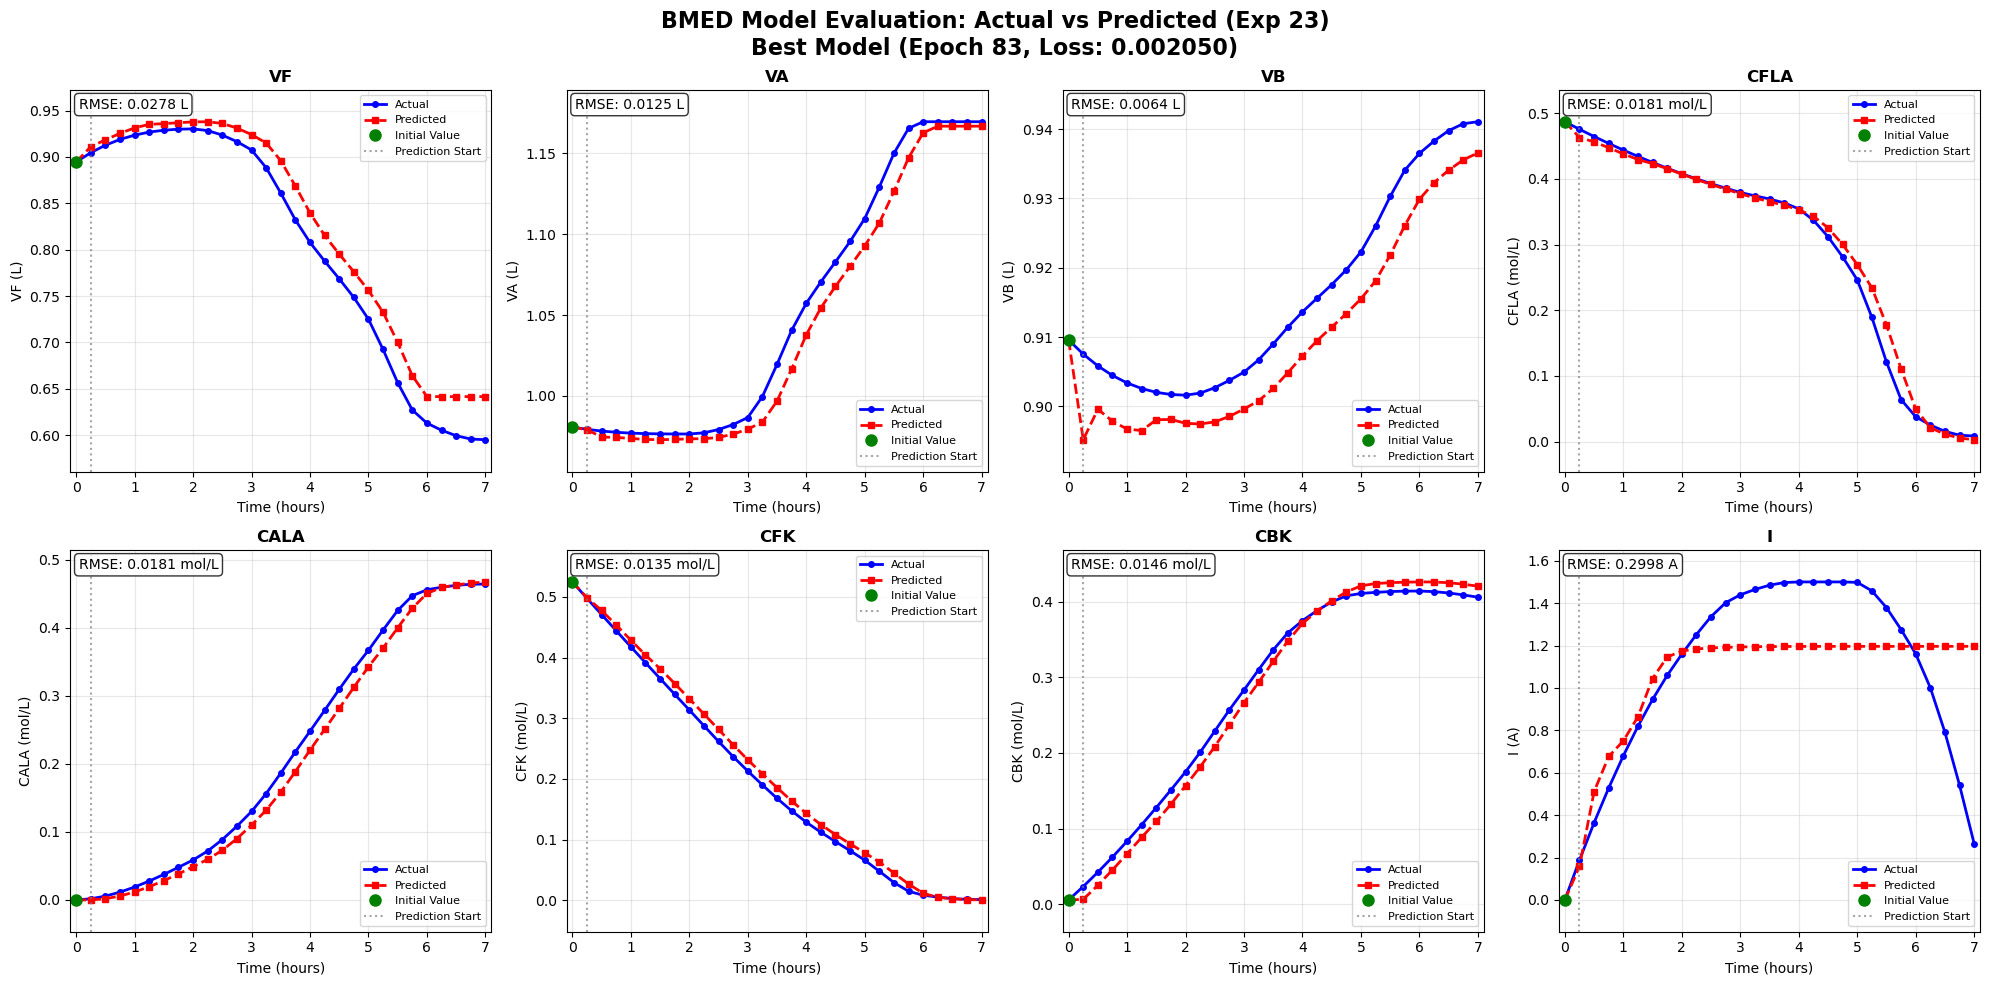

MODEL EVALUATION RESULTS - Experiment 23
Best Model (Epoch 83, Loss: 0.002050)
Initial time point: t = 0.00 hours
Prediction starts from: t = 0.25 hours
Total sequence length: 29 points
Prediction sequence length: 28 points
--------------------------------------------------------------------------------
VF    : Initial=0.8946 L, RMSE=0.0278 L, MAE=0.0240 L, MAPE=3.35%, R²=0.9526
VA    : Initial=0.9808 L, RMSE=0.0125 L, MAE=0.0097 L, MAPE=0.91%, R²=0.9746
VB    : Initial=0.9096 L, RMSE=0.0064 L, MAE=0.0062 L, MAPE=0.67%, R²=0.7920
CFLA  : Initial=0.4871 mol/L, RMSE=0.0181 mol/L, MAE=0.0107 mol/L, MAPE=13.03%, R²=0.9871
CALA  : Initial=0.0001 mol/L, RMSE=0.0181 mol/L, MAE=0.0150 mol/L, MAPE=18.56%, R²=0.9890
CFK   : Initial=0.5247 mol/L, RMSE=0.0135 mol/L, MAE=0.0119 mol/L, MAPE=16.81%, R²=0.9928
CBK   : Initial=0.0056 mol/L, RMSE=0.0146 mol/L, MAE=0.0137 mol/L, MAPE=10.34%, R²=0.9884
I     : Initial=0.0000 A, RMSE=0.2998 A, MAE=0.2299 A, MAPE=32.54%, R²=0.4822
--------------------------

In [ ]:
# 모델 평가: 실제 vs 예측 데이터 비교 (denormalized 원본 단위, Best Model 사용)
import matplotlib.pyplot as plt
import numpy as np

# normalization에 사용된 range_mm 복원 (전체 데이터 기준)
original_df = pd.read_csv('BMED_DATA_AG.csv')
original_df = original_df[original_df['exp'].isin([0, 1])]

range_mm = {
    'V': {'min': original_df['V'].min()*0.8, 'max': original_df['V'].max()*1.2},
    'E': {'min': original_df['E'].min()*0.8, 'max': original_df['E'].max()*1.2},
    'VF': {'min': original_df['VF'].min()*0.8, 'max': original_df['VF'].max()*1.2},
    'VA': {'min': original_df['VA'].min()*0.8, 'max': original_df['VA'].max()*1.2},
    'VB': {'min': original_df['VB'].min()*0.8, 'max': original_df['VB'].max()*1.2},
    'CFLA': {'min': 0, 'max': original_df['CFLA'].max()*1.2},
    'CALA': {'min': 0, 'max': original_df['CALA'].max()*1.2},
    'CFK': {'min': 0, 'max': original_df['CFK'].max()*1.2},
    'CBK': {'min': 0, 'max': original_df['CBK'].max()*1.2},
    'I': {'min': 0, 'max': original_df['I'].max()*1.2},
}

def denormalize_data(normalized_data, feature_name):
    """정규화된 데이터를 원래 단위로 복원"""
    if feature_name in range_mm:
        min_val = range_mm[feature_name]['min']
        max_val = range_mm[feature_name]['max']
        return normalized_data * (max_val - min_val) + min_val
    return normalized_data

# feature 정보 정의
feature_names = ['VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
feature_indices = [2, 3, 4, 5, 6, 7, 8, 9]
feature_units = ['L', 'L', 'L', 'mol/L', 'mol/L', 'mol/L', 'mol/L', 'A']

# Best model 확인
if best_model is None:
    print("❌ Best model이 저장되지 않았습니다. 현재 모델을 사용합니다.")
    evaluation_model = model
    model_info = "Current Model"
else:
    evaluation_model = best_model
    model_info = f"Best Model (Epoch {best_epoch}, Loss: {best_train_loss:.6f})"
    print(f"✅ {model_info} 사용하여 평가를 진행합니다.")

# 실험 선택 옵션
exp_to_evaluate = 23  # 0 또는 1로 변경 가능
print(f"📊 평가 대상 실험: Experiment {exp_to_evaluate}")

# 사용 가능한 실험 확인
available_exps = []
for i, (input_seq, seq_lengths) in enumerate(dataloader):
    available_exps.append(i)
print(f"📋 사용 가능한 실험: {available_exps}")

evaluation_model.eval()
with torch.no_grad():
    # 선택된 실험의 데이터 가져오기
    for i, (input_seq, seq_lengths) in enumerate(dataloader):
        if i == exp_to_evaluate:
            selected_input_seq = input_seq.to(device)
            selected_seq_lengths = seq_lengths.to(device)
            break
    else:
        print(f"⚠️ 실험 {exp_to_evaluate}을 찾을 수 없습니다. 첫 번째 실험을 사용합니다.")
        selected_input_seq, selected_seq_lengths = next(iter(dataloader))
        selected_input_seq = selected_input_seq.to(device)
        selected_seq_lengths = selected_seq_lengths.to(device)
        exp_to_evaluate = 0
    
    # Teacher forcing 데이터 준비
    inputs, targets, target_seq_lengths = prepare_teacher_forcing_data(selected_input_seq, selected_seq_lengths)
    
    # Best model로 예측
    predictions = evaluation_model(inputs, target_seq_lengths)
    
    # CPU로 이동하여 시각화 준비
    predictions = predictions.cpu().numpy()
    targets = targets.cpu().numpy()
    input_seq_cpu = selected_input_seq.cpu().numpy()
    
    # 첫 번째 샘플 (batch의 첫 번째) 사용
    pred_sample = predictions[0]
    actual_sample = targets[0]
    initial_sample = input_seq_cpu[0]  # 초기값 포함된 전체 시퀀스
    seq_len = target_seq_lengths[0].item()
    full_seq_len = selected_seq_lengths[0].item()
    
    # 실제 시퀀스 길이만큼만 사용
    pred_sample = pred_sample[:seq_len]
    actual_sample = actual_sample[:seq_len]
    initial_sample = initial_sample[:full_seq_len]

# 실험 조건 정보 출력
print(f"🔬 실험 조건:")
print(f"   - 실험 번호: {exp_to_evaluate}")
print(f"   - 전압(V): {denormalize_data(initial_sample[0, 0], 'V'):.1f} V")
print(f"   - 외부 전해질 농도(E): {denormalize_data(initial_sample[0, 1], 'E'):.2f} M")
print(f"   - 시퀀스 길이: {full_seq_len} 시점 ({full_seq_len*0.25:.2f} 시간)")

# 시간 축 생성
time_points = np.arange(full_seq_len) * 0.25  # 전체 시간축 (0.0부터)

# 예측값을 초기값과 연결하여 전체 시퀀스 구성
prediction_full = np.zeros((full_seq_len, 10))
# 첫 번째 시점은 초기값 사용
prediction_full[0] = initial_sample[0]
# 나머지 시점은 모델 예측값 사용
prediction_full[1:seq_len+1] = pred_sample

# 2x4 subplot 생성
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle(f'BMED Model Evaluation: Actual vs Predicted (Exp {exp_to_evaluate})\n{model_info}', fontsize=16, fontweight='bold')

for i, (feature_name, feature_idx, unit) in enumerate(zip(feature_names, feature_indices, feature_units)):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    # 데이터를 원래 단위로 denormalize
    actual_denorm = denormalize_data(initial_sample[:, feature_idx], feature_name)
    pred_denorm = denormalize_data(prediction_full[:seq_len+1, feature_idx], feature_name)
    
    # 실제 데이터 (전체 시퀀스)
    ax.plot(time_points, actual_denorm, 'b-', linewidth=2, label='Actual', marker='o', markersize=4)
    
    # 예측 데이터 (초기값부터 연결된 전체 시퀀스)
    ax.plot(time_points[:seq_len+1], pred_denorm, 'r--', linewidth=2, label='Predicted', marker='s', markersize=4)
    
    # 초기값 강조 표시
    ax.plot(time_points[0], actual_denorm[0], 'go', markersize=8, label='Initial Value')
    
    # 예측 시작점 표시
    ax.axvline(x=time_points[1], color='gray', linestyle=':', alpha=0.7, label='Prediction Start')
    
    # 그래프 설정
    ax.set_title(f'{feature_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time (hours)', fontsize=10)
    ax.set_ylabel(f'{feature_name} ({unit})', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # RMSE 계산 및 표시 (denormalized 값으로, 예측 구간만)
    actual_pred_denorm = denormalize_data(actual_sample[:, feature_idx], feature_name)
    pred_pred_denorm = denormalize_data(pred_sample[:, feature_idx], feature_name)
    rmse = np.sqrt(np.mean((actual_pred_denorm - pred_pred_denorm)**2))
    ax.text(0.02, 0.98, f'RMSE: {rmse:.4f} {unit}', transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # y축 범위 설정 (전체 데이터 고려)
    all_values = np.concatenate([actual_denorm, pred_denorm])
    y_min = all_values.min()
    y_max = all_values.max()
    y_range = y_max - y_min
    if y_range > 0:
        ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    
    # x축 범위 설정
    ax.set_xlim(-0.1, time_points[seq_len] + 0.1)

plt.tight_layout()
plt.show()

# 전체 성능 지표 계산 (denormalized)
print("="*80)
print(f"MODEL EVALUATION RESULTS - Experiment {exp_to_evaluate}")
print(f"{model_info}")
print("="*80)
print(f"Initial time point: t = {time_points[0]:.2f} hours")
print(f"Prediction starts from: t = {time_points[1]:.2f} hours")
print(f"Total sequence length: {full_seq_len} points")
print(f"Prediction sequence length: {seq_len} points")
print("-"*80)

total_rmse = 0
for i, (feature_name, unit) in enumerate(zip(feature_names, feature_units)):
    feature_idx = feature_indices[i]
    
    # denormalized 값으로 성능 지표 계산
    actual_vals_denorm = denormalize_data(actual_sample[:, feature_idx], feature_name)
    pred_vals_denorm = denormalize_data(pred_sample[:, feature_idx], feature_name)
    initial_val_denorm = denormalize_data(initial_sample[0, feature_idx], feature_name)
    
    # 성능 지표 계산
    rmse = np.sqrt(np.mean((actual_vals_denorm - pred_vals_denorm)**2))
    mae = np.mean(np.abs(actual_vals_denorm - pred_vals_denorm))
    mape = np.mean(np.abs((actual_vals_denorm - pred_vals_denorm) / (actual_vals_denorm + 1e-8))) * 100  # MAPE (%)
    r2 = 1 - (np.sum((actual_vals_denorm - pred_vals_denorm)**2) / np.sum((actual_vals_denorm - np.mean(actual_vals_denorm))**2))
    
    print(f"{feature_name:6s}: Initial={initial_val_denorm:.4f} {unit}, RMSE={rmse:.4f} {unit}, MAE={mae:.4f} {unit}, MAPE={mape:.2f}%, R²={r2:.4f}")
    total_rmse += rmse

avg_rmse = total_rmse / len(feature_names)
print("-"*80)
print(f"AVERAGE: RMSE={avg_rmse:.4f} (mixed units)")
if best_model is not None:
    print(f"✅ Best training loss: {best_train_loss:.6f} (Epoch {best_epoch})")
print("="*80)

# 실험 변경 방법 안내
print(f"\n💡 실험 변경하려면:")
print(f"   - 코드의 'exp_to_evaluate = 0' 부분을 수정하세요")
print(f"   - 사용 가능한 실험: {available_exps}")
print(f"   - 현재 설정: Experiment {exp_to_evaluate}")